# Filter Design (FIR ,IIR ,CIC)
## by :
### Hazem Yasser Mahmoud 


## imports

In [ ]:
import numpy as np
from scipy.signal import firwin, remez, freqz, kaiserord, iirnotch, lfilter, tf2zpk
import matplotlib.pyplot as plt

## Polyphase filter for rational resampling

### Promplems and Solutions
1. For prpoer resampling the fir filter need to be $w_c = \frac{1}{\max(L, M)} \cdot \frac{F_s}{2}$

2. so we Design a Prototype FIR at 1.5 wher 1.4 lesss than .25dB and after 1.6 less than -80dB 

3. implementing this prototype FIR in polyphase structure give effective filtering at 3 MHz


### DESIGN

Estimated filter order: 227


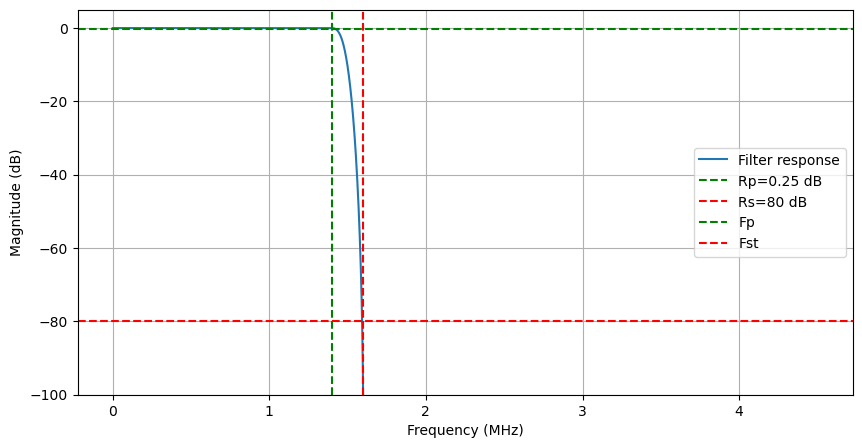

In [ ]:

# Specs
Fs  = 9e6
Fp  = 1.4e6
Fst = 1.6e6

# Desired ripple/attenuation
Rp = 0.25   # passband ripple in dB
Rs = 80     # stopband attenuation in dB

# Convert to linear ripple/attenuation
delta_p = (10**(Rp/20) - 1) / (10**(Rp/20) + 1)   # passband ripple (linear)
delta_s = 10**(-Rs/20)                            # stopband ripple (linear)

# Relative weights: higher weight on passband or stopband as needed
# (choose ratio based on importance)
weights = [1/delta_p, 1/delta_s]

# Bands in Hz
bands   = [0, Fp, Fst, Fs/2]   # passband 0–Fp, stopband Fst–Fs/2
desired = [1, 0]               # gain in each band

# Estimate number of taps (Kaiser formula as starting point)

N, beta = kaiserord(Rs, (Fst-Fp)/(Fs/2))
numtaps = N if N % 2 else N+1  # odd length

print(f"Estimated filter order: {numtaps}")

# Design equiripple filter
h = remez(numtaps, bands, desired, weight=weights, fs=Fs)

# Frequency response
w, H = freqz(h, worN=8192, fs=Fs)
H_db = 20*np.log10(np.maximum(np.abs(H), 1e-12))

# Plot
plt.figure(figsize=(10,5))
plt.plot(w/1e6, H_db, label="Filter response")
plt.axhline(-Rp, color="g", linestyle="--", label="Rp=0.25 dB")
plt.axhline(-Rs, color="r", linestyle="--", label="Rs=80 dB")
plt.axvline(Fp/1e6, color="g", linestyle="--", label="Fp")
plt.axvline(Fst/1e6, color="r", linestyle="--", label="Fst")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.ylim([-100, 5])
plt.grid()
plt.legend()
plt.show()

### export to quantized

In [5]:
nbits = 16
scale = 2**(nbits - 1)

h_fixed = np.round(h * scale)
h_fixed = np.clip(h_fixed, -scale, scale - 1).astype(np.int16)

np.savetxt("coeffs_fixed_q15.txt", h_fixed, fmt="%d")

## biquad IIR Notch at 2.4 MHz

### Promplems and Solutions
1. original sampling frequency is 9 MHz so Max freq component Present is 4.5 MHz
2. any frequency higher would have been either filtered by the previous filter
or aliased around the 4.5 so an interfernce at 5 would be at 4 if not filtered
3. after the resampling filter the original interfernce at 4 (previously 5 ) is already filtered
4. so we design only for the IIR at 2.4
#### numerical stabilty
- hor numerical stabilty we design biquad iir and implement DFII



### Design

In [8]:

# ==============================================================
# 1. Design notch filter (floating point)
# ==============================================================

fs = 6e6        # Sampling frequency
f0 = 2.4e6      # Notch frequency
Q = 30          # Quality factor

# Design IIR notch (2nd order)
b, a = iirnotch(f0/(fs/2), Q)

print("Floating-point coefficients:")
print("b =", b)
print("a =", a)


Floating-point coefficients:
b = [0.95977357 1.55294626 0.95977357]
a = [1.         1.55294626 0.91954714]


In [9]:

# ==============================================================
# 2. Quantize to Q1.14 fixed-point (16-bit signed)
# ==============================================================

frac_bits = 14
scale = 2**frac_bits

def float_to_q14(x):
    return np.round(x * scale).astype(int)

def q14_to_float(x):
    return x / scale

b_q14 = float_to_q14(b)
a_q14 = float_to_q14(a)

print("\nQ1.14 integer coefficients:")
print("b_q14 =", b_q14)
print("a_q14 =", a_q14)

# Convert back to float for simulation
b_fixed = q14_to_float(b_q14)
a_fixed = q14_to_float(a_q14)

print("\nQ1.14 quantized coefficients (float equivalent):")
print("b_fixed =", b_fixed)
print("a_fixed =", a_fixed)



Q1.14 integer coefficients:
b_q14 = [15725 25443 15725]
a_q14 = [16384 25443 15066]

Q1.14 quantized coefficients (float equivalent):
b_fixed = [0.95977783 1.55291748 0.95977783]
a_fixed = [1.         1.55291748 0.91955566]


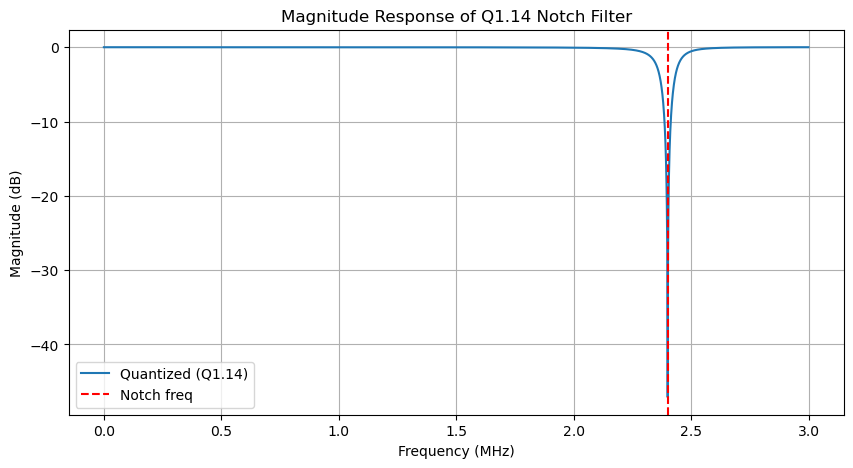

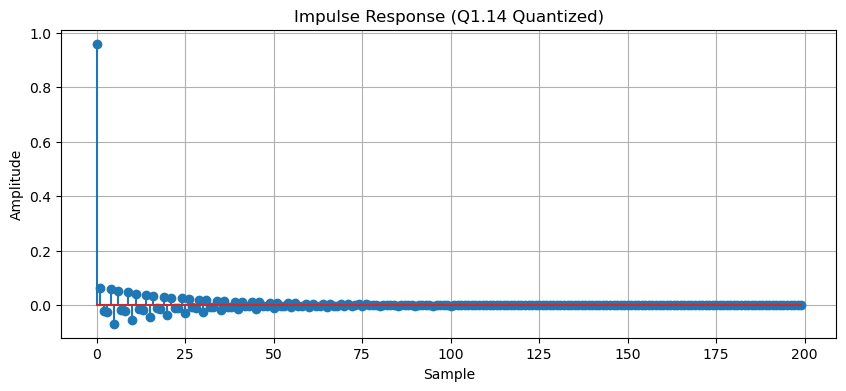

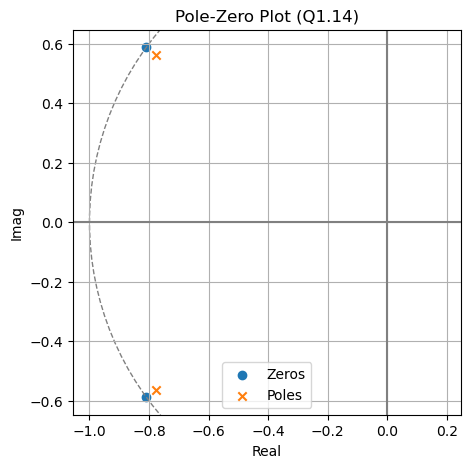


Filter stability after quantization: Stable ✅

Saved coefficients to notch_b_q14.txt and notch_a_q14.txt


In [10]:

# ==============================================================
# 3. Frequency response (quantized)
# ==============================================================

w, h = freqz(b_fixed, a_fixed, worN=4096, fs=fs)

plt.figure(figsize=(10,5))
plt.plot(w/1e6, 20*np.log10(np.abs(h)), label='Quantized (Q1.14)')
plt.title('Magnitude Response of Q1.14 Notch Filter')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.axvline(f0/1e6, color='r', linestyle='--', label='Notch freq')
plt.legend()
plt.show()

# ==============================================================
# 4. Impulse response (quantized)
# ==============================================================

impulse = np.zeros(200)
impulse[0] = 1.0
resp = lfilter(b_fixed, a_fixed, impulse)

plt.figure(figsize=(10, 4))
plt.stem(resp)
plt.title('Impulse Response (Q1.14 Quantized)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
# ==============================================================
# 5. Pole–zero plot (quantized)
# ==============================================================

z, p, k = tf2zpk(b_fixed, a_fixed)

plt.figure(figsize=(5,5))
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.scatter(np.real(z), np.imag(z), marker='o', label='Zeros')
plt.scatter(np.real(p), np.imag(p), marker='x', label='Poles')
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.title('Pole-Zero Plot (Q1.14)')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

# ==============================================================
# 6. Check stability
# ==============================================================

stable = np.all(np.abs(p) < 1)
print("\nFilter stability after quantization:", "Stable ✅" if stable else "UNSTABLE ⚠️")

# ==============================================================
# 7. Save fixed-point coefficients (for HDL)
# ==============================================================

np.savetxt("notch_b_q14.txt", b_q14, fmt="%d")
np.savetxt("notch_a_q14.txt", a_q14, fmt="%d")

print("\nSaved coefficients to notch_b_q14.txt and notch_a_q14.txt")

# CIC decimation filter 

##### CIC Filter Specs:
#####   - Configurable decimation (1–16)
#####   - Passband ripple ≤ 0.5 dB (with compensation FIR)
#####   - Stopband attenuation ≥ 60 dB
#####   - Must handle internal bit growth


Designing for R = 2
CIC diagnostics:
  CIC DC gain = 32
  finite check: any NaN/Inf?  False
  finite check: any NaN/Inf?  False
  Quantized range: min=-2576 max=14420
  Saved quantized coefficients to comp_R2.txt


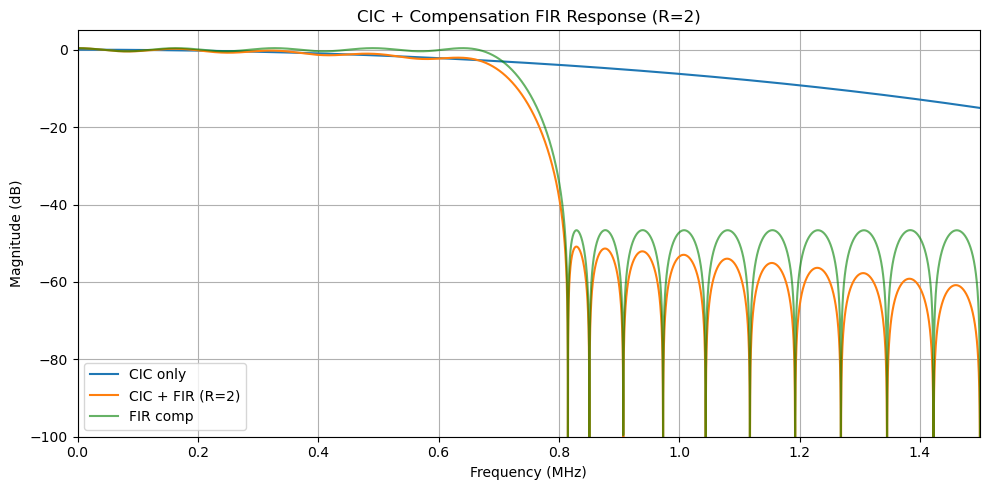


Designing for R = 4
CIC diagnostics:
  CIC DC gain = 1024
  finite check: any NaN/Inf?  False
  finite check: any NaN/Inf?  False
  Quantized range: min=-2576 max=14420
  Saved quantized coefficients to comp_R4.txt


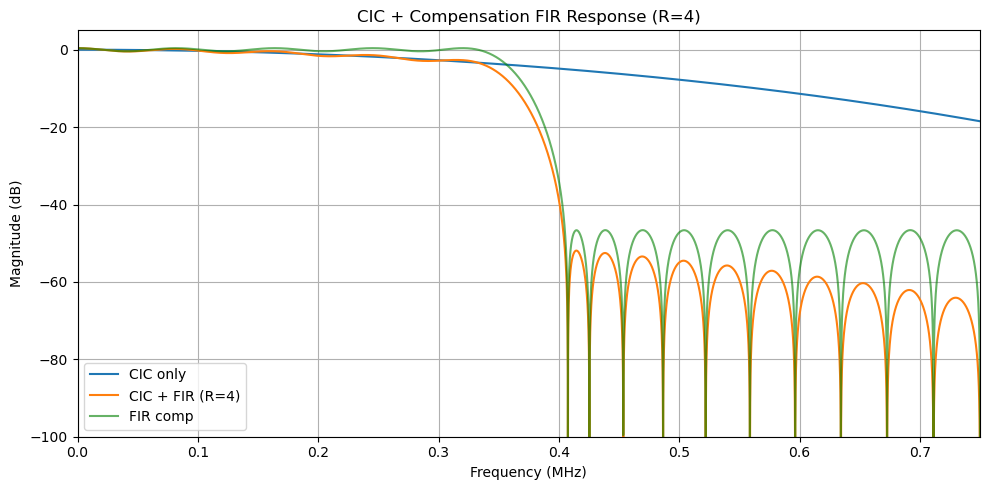


Designing for R = 8
CIC diagnostics:
  CIC DC gain = 32768
  finite check: any NaN/Inf?  False
  finite check: any NaN/Inf?  False
  Quantized range: min=-2576 max=14420
  Saved quantized coefficients to comp_R8.txt


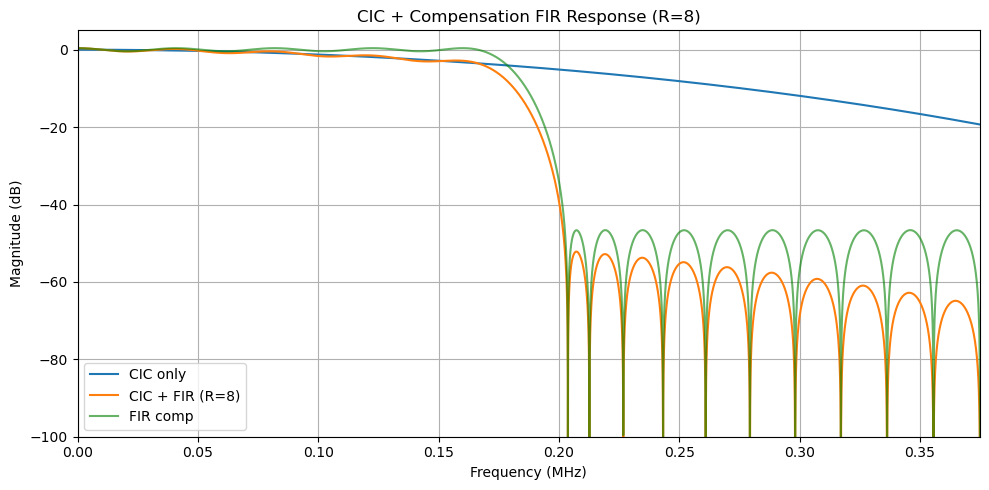


Designing for R = 16
CIC diagnostics:
  CIC DC gain = 1048576
  finite check: any NaN/Inf?  False
  finite check: any NaN/Inf?  False
  Quantized range: min=-2576 max=14420
  Saved quantized coefficients to comp_R16.txt


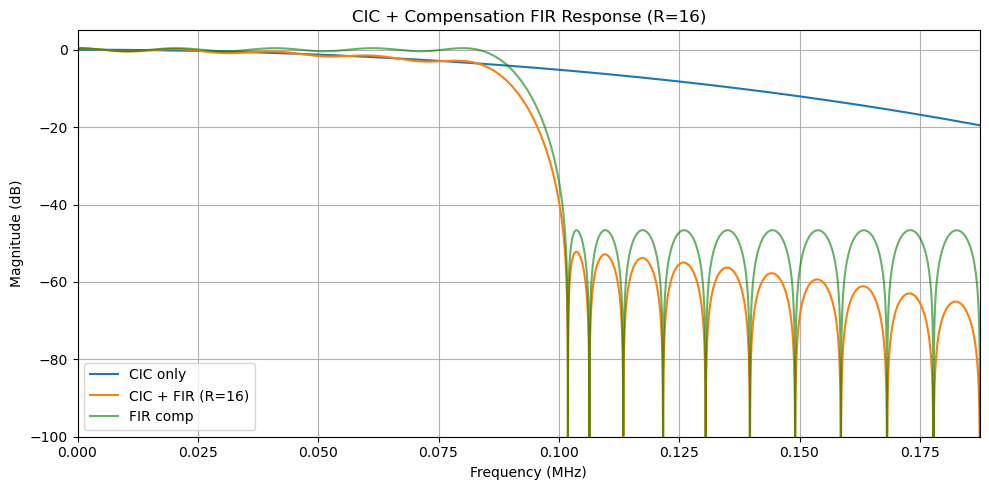

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz

# ---------------------------
# Parameters
# ---------------------------
fs_in = 6e6        # input sampling rate (Hz)
N = 5              # number of CIC stages
M = 1              # differential delay
numtaps = 40
nfft = 16384
eps = 1e-12

# Quantization parameters (s.1.15)
N_FRAC = 15
SCALE = 2 ** N_FRAC
MAX_Q = (2 ** (N_FRAC + 1)) - 1

# ---------------------------
# Function to quantize coefficients to Q1.15
# ---------------------------
def quantize_q15(x):
    x = np.clip(x, -1, 1 - 1/SCALE)
    q = np.round(x * SCALE).astype(int)
    return q, q / SCALE

# ---------------------------
# Main Loop for different decimation factors
# ---------------------------
R_values = [2, 4, 8, 16]

for R in R_values:
    print("\n==============================")
    print(f"Designing for R = {R}")
    print("==============================")

    fs_out = fs_in / R
    w_out = np.linspace(0, np.pi, nfft)
    f_out = w_out * fs_out / (2 * np.pi)

    # ---------------------------
    # CIC Response (output-domain)
    # ---------------------------
    num = np.sin(M * w_out / 2.0)
    den = np.sin(w_out / (2.0 * R))
    den[np.abs(den) < eps] = eps
    H_cic_out = (num / (R * M * den)) ** N
    

    print("CIC diagnostics:")
    print("  CIC DC gain =", ((R * M) ** N))
    print("  finite check: any NaN/Inf? ", np.any(~np.isfinite(H_cic_out)))

    # ---------------------------
    # Compensation FIR Design
    # ---------------------------
    f_pass = 0.45 * (fs_out / 2.0)
    bands = [0, f_pass, f_pass * 1.2, fs_out / 2.0]
    desired = [1, 0]
    weights = [1, 10]

    comp = remez(numtaps, bands, desired, weight=weights, fs=fs_out)
    w_comp, H_comp = freqz(comp, 1, worN=w_out)
    H_total = H_cic_out * H_comp


    print("  finite check: any NaN/Inf? ", np.any(~np.isfinite(H_comp)))

    # ---------------------------
    # Quantize to Q1.15
    # ---------------------------
    q15_int, q15_float = quantize_q15(comp)
    print(f"  Quantized range: min={q15_int.min()} max={q15_int.max()}")

    # ---------------------------
    # Export coefficients
    # ---------------------------
    filename = f"comp_R{R}.txt"
    np.savetxt(filename, q15_int, fmt="%d")
    print(f"  Saved quantized coefficients to {filename}")

    # ---------------------------
    # Optional Plot
    # ---------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(f_out / 1e6, 20*np.log10(np.abs(H_cic_out)+1e-18), label="CIC only")
    plt.plot(f_out / 1e6, 20*np.log10(np.abs(H_total)+1e-18), label=f"CIC + FIR (R={R})")
    plt.plot(f_out / 1e6, 20*np.log10(np.abs(H_comp)+1e-18), color="green", alpha=0.6, label="FIR comp")
    plt.title(f"CIC + Compensation FIR Response (R={R})")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, fs_out/2/1e6)
    plt.ylim(-100, 5)
    plt.tight_layout()
    plt.show()